# Theft Crime Prediction using KDE, LDA and Sentiment Analysis in Chicago

In [1]:
%matplotlib inline

import os
import glob
import itertools
import functools
import collections

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from tqdm import tqdm_notebook, tqdm

from utils.consts import START_DATE, END_DATE, \
                         RAW_CRIMES_DATA_PATH, PROCESSED_CRIMES_DATA_PATH, \
                         RAW_TWEETS_DATA_WILDCARD_PATH, PROCESSED_TWEETS_DATA_PATH, \
                         CSV_DATE_FORMART

from utils.lda import print_top_words_LDA, print_top_words_LDA, get_topic_top_words_LDA

from utils.surveillance import generate_all_data_surveillance_data, \
                               generate_one_step_datasets, generate_surveillance_data, calc_AUCs
    
from utils.visualization import plot_contour, plot_scatter, plot_imshow, plot_log_reg_coef, plot_surveillance_data


/anaconda3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
import warnings
warnings.simplefilter('ignore')

# High level Architecture

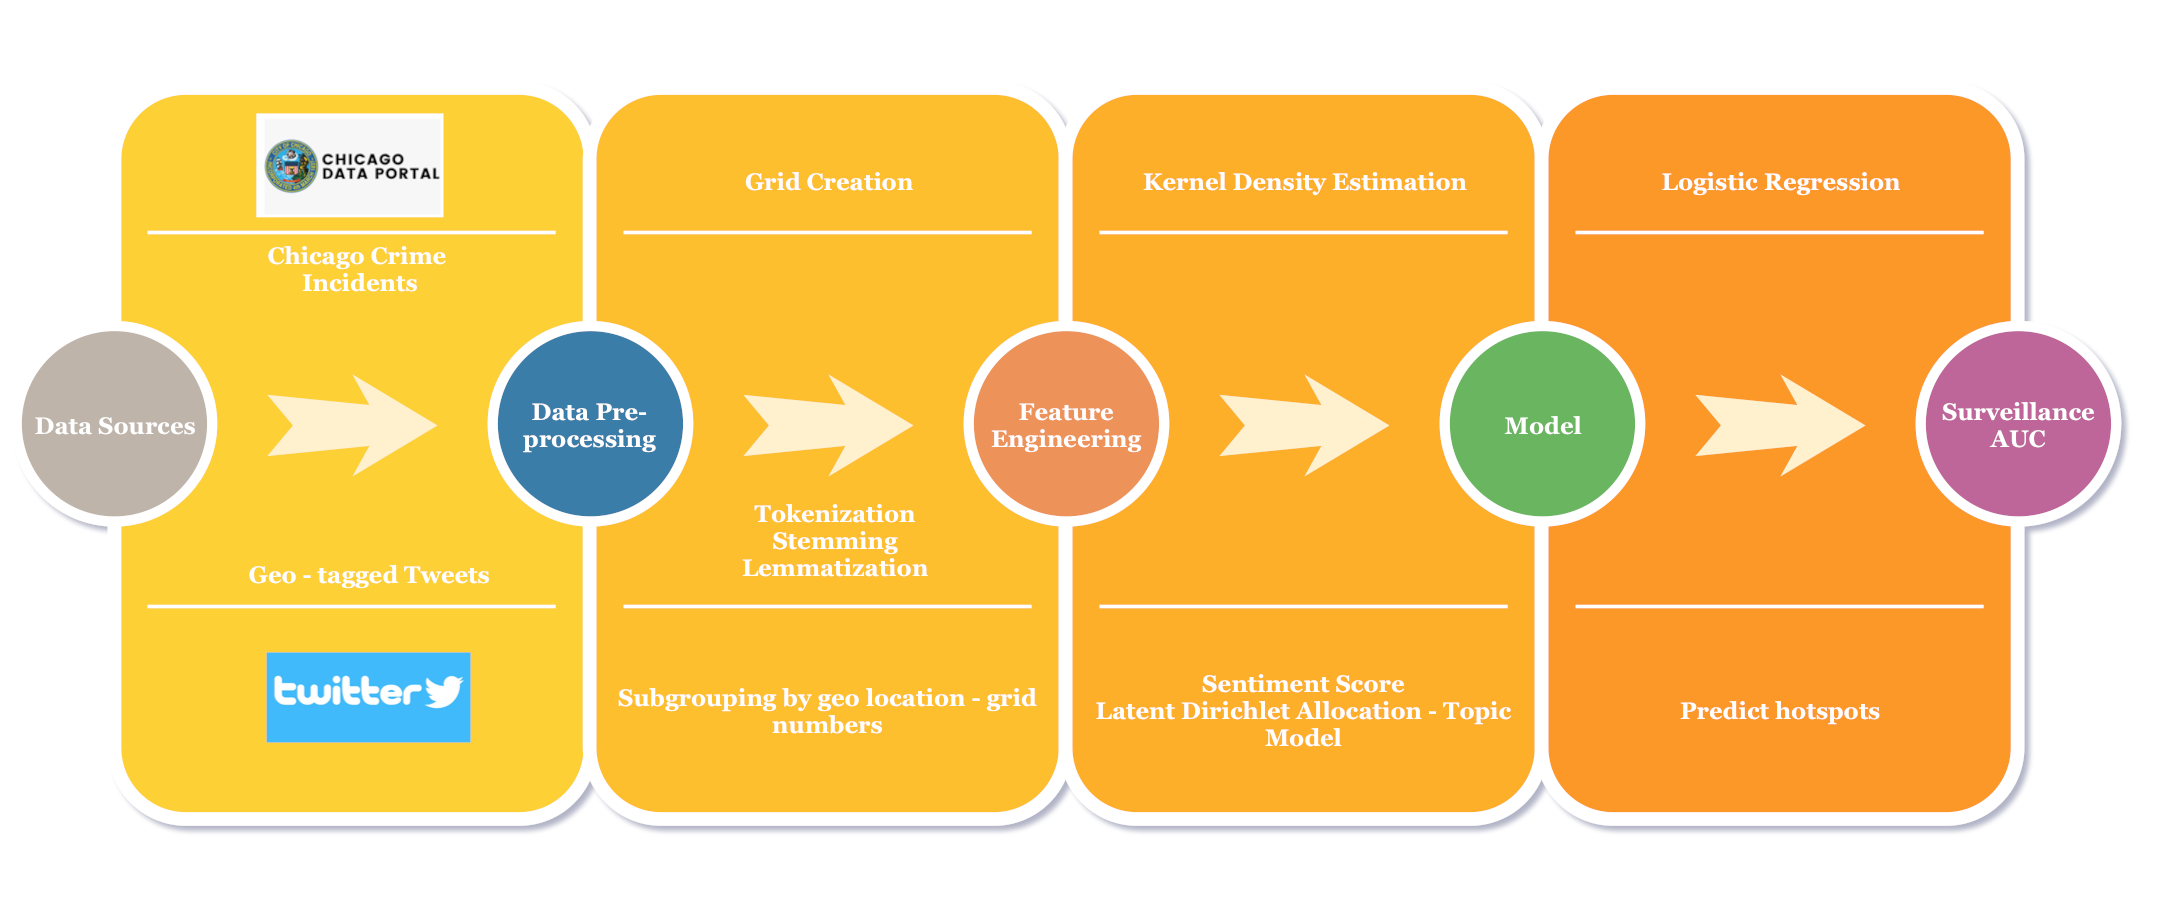

In [3]:
from IPython.display import Image
PATH = "/Users/varsha/Desktop/File/My code/"
Image(filename = PATH + "data.png", width=1000, height=1000)





## Research Time Frame

In [4]:
print(START_DATE, '--->', END_DATE)

2019-06-22 ---> 2019-08-01


## Data Sources & Preprocessing

### Chicago Crimes Incidents (only THEFT)

### In order to run the model on different type of crime, change the parameter in consts.py   CRIME_TYPE = " "

In [5]:
if not os.path.exists(PROCESSED_CRIMES_DATA_PATH):
    !python3 ./preprocess_crimes_data.py {RAW_CRIMES_DATA_PATH}  {PROCESSED_CRIMES_DATA_PATH}

In [6]:
crimes_data = pd.read_csv(PROCESSED_CRIMES_DATA_PATH)
crimes_data['timestamp'] = pd.to_datetime(crimes_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()

In [7]:
len(crimes_data)

7508

In [8]:
crimes_data['timestamp'].agg(['min', 'max'])

min   2019-06-22
max   2019-07-31
Name: timestamp, dtype: datetime64[ns]

### Tweets
### Processing the tweets by applying tokenization, stemming , lemmatization




In [9]:
if not os.path.exists(PROCESSED_TWEETS_DATA_PATH):
    !python3 -W ignore ./preprocess_tweets_data.py {RAW_TWEETS_DATA_WILDCARD_PATH} {PROCESSED_TWEETS_DATA_PATH}

In [10]:
tweets_data = pd.read_csv(PROCESSED_TWEETS_DATA_PATH)
tweets_data['timestamp'] = pd.to_datetime(tweets_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()
tweets_data['tokens'] = tweets_data['tokens'].apply(lambda x: eval(x))

In [11]:
len(tweets_data)

60281

In [12]:
tweets_data.head(3)

,Unnamed: 0,id,timestamp,latitude,longitude,text,latitude_index,longitude_index,tokens
0,19,1151318285385789445,2019-07-17,41.845718,-87.889338,"Interested in a job in #Westchester, IL? This ...",22,111,"[Interested, in, a, job, in, #Westchester, ,, ..."
1,22,1151318292482707459,2019-07-17,41.883222,-87.632496,Last 36 hours of our trip. Tomorrow we go home...,129,131,"[Last, 36, hours, of, our, trip, ., Tomorrow, ..."
2,25,1151318313689071617,2019-07-17,41.903050,-87.668940,"I'm at Wicker Park Athletic Club in Chicago, I...",114,142,"[I'm, at, Wicker, Park, Athletic, Club, in, Ch..."


In [13]:
tweets_data['timestamp'].agg(['min', 'max'])

min   2019-06-22
max   2019-07-28
Name: timestamp, dtype: datetime64[ns]

# Tweet with Sentiment Analysis

In [14]:
%%time

from utils.sentiment.sentiment import calculate_sentiment_tweet

Length of the testing Corpus : 10662
Adding unigrams and bigrams sentiment scores 

average fit_time : 0.23594944477081298
average score_time : 0.005893611907958984
average test_f1_micro : 0.7554900886087512
average test_f1_macro : 0.7554053496579932
average test_precision_micro : 0.7554900886087512
average test_precision_macro : 0.7558688268181593
average test_recall_micro : 0.7554900886087512
average test_recall_macro : 0.7554900886087512
                                    Topics    Results
0               Number of tweets in Corpus      10662
1  Average micro test precision percentage  75.5490 %
2  Average macro test precision percentage  75.5868 %
3     Average micro test recall percentage  75.5490 %
4     Average macro test recall percentage  75.5490 %
CPU times: user 5.24 s, sys: 122 ms, total: 5.36 s
Wall time: 5.37 s


In [15]:
%%time

tweets_data['sentiment'] = tweets_data['tokens'].apply(lambda x: calculate_sentiment_tweet(' '.join(x)))

CPU times: user 58.2 s, sys: 247 ms, total: 58.4 s
Wall time: 58.3 s


## # Training the data for 31 days  and then successive single day for evaluation

### Generating the train dataset with all the features (KDA, SENTIMENT, LDA) and the evaluation dataset (successive day crime incidents)

#KDA
#KDA+SENTIMENT
#KDA+LDA
#KDA+LDA+SENTIMENT

In [16]:
%%time

train_dataset, evaluation_dataset = generate_one_step_datasets(crimes_data,
                                                               tweets_data,
                                                               START_DATE,
                                                               31)

CPU times: user 10min 12s, sys: 13.3 s, total: 10min 25s
Wall time: 3min 2s


In [17]:
train_dataset['X'].head(5)

,latitude,longitude,latitude_index,longitude_index,KDE,SENTIMENT,T000,T001,T002,T003,...,T340,T341,T342,T343,T344,T345,T346,T347,T348,T349
0,41.880842,-87.771813,14,26,-8.930775e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,41.986927,-87.665460,23,37,-9.040460e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,41.944129,-87.760610,15,33,-9.158154e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,41.889407,-87.644834,24,26,-8.522372e+06,-0.234995,0.000476,0.000476,0.193007,0.000476,...,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476
4,41.916336,-87.634797,25,29,-8.618034e+06,-0.049849,0.000012,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.101175,0.000012,0.000012


In [18]:
#train_dataset['Y']

## Train Dataset combining all features

# KDE Scatter Plot

Text(0.5, 1.0, 'Crime Incidents: 2019-06-22+31 days')

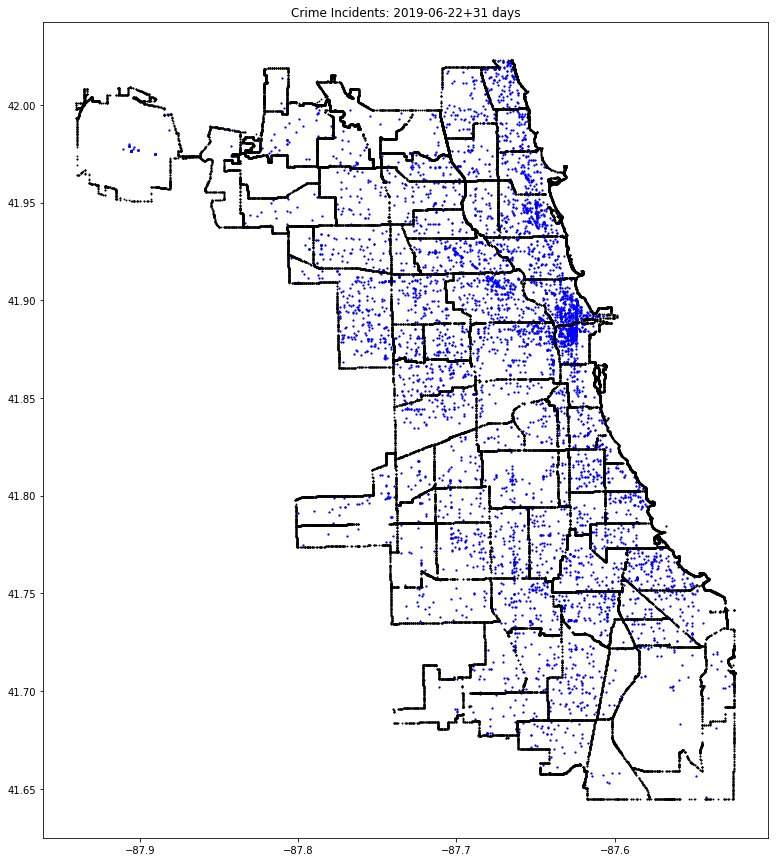

In [19]:
plot_scatter(train_dataset['X'][train_dataset['Y']][['latitude', 'longitude']])
plt.title('Crime Incidents: {}+31 days'.format(START_DATE))

Text(0.5, 1.0, 'KDE of Crime Incidents: 2019-06-22+31 days')

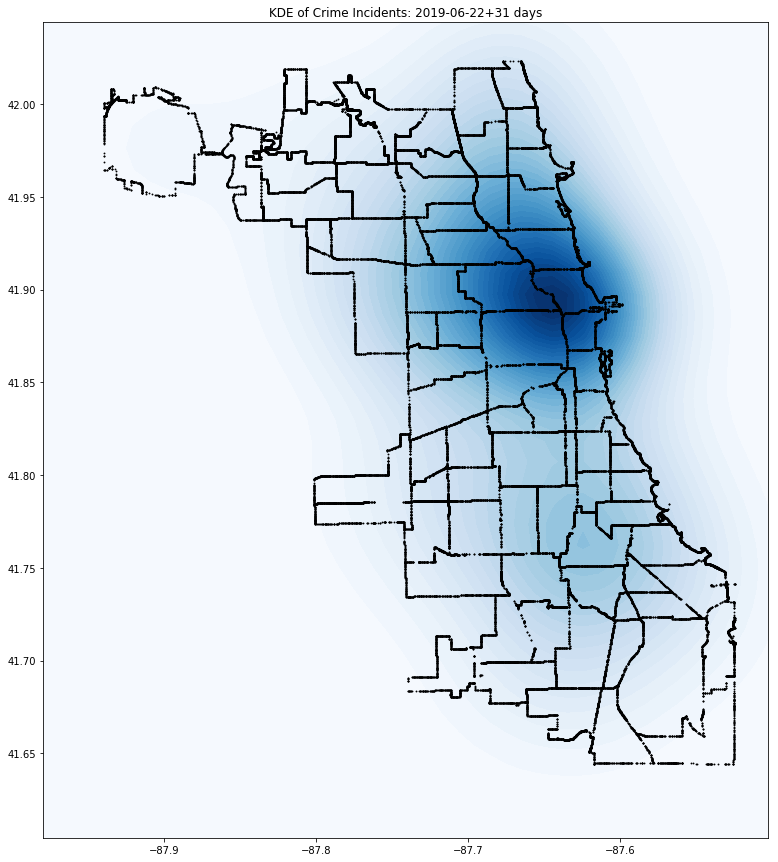

In [20]:
plot_contour(train_dataset['KDE'])
plt.title('KDE of Crime Incidents: {}+31 days'.format(START_DATE))

#### Sentiment

Text(0.5, 1.0, 'Sentiment Histogram & Distribution over Geo Documents')

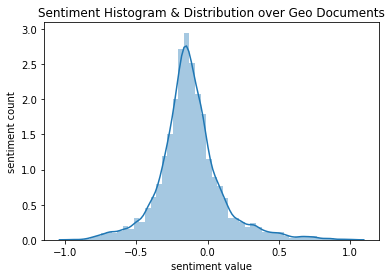

In [21]:
sns.distplot(train_dataset['SENTIMENT'], norm_hist=True)
plt.xlabel('sentiment value')
plt.ylabel('sentiment count')
plt.title('Sentiment Histogram & Distribution over Geo Documents')

In [22]:
train_dataset['Y'].value_counts()

True     5952
False    1470
Name: crime, dtype: int64

In [23]:
#train_dataset

In [24]:
#threat_datasets

#### LDA

In [25]:
print_top_words_LDA(train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 15)

Topic #0: Rosemont | url | … | Best | , | films | July | concert | del | friends | Day | I | opportunity | experience | metal
Topic #1: level | Eisenhower | NB | Tri-State | Off-ramp | closed | MAYBACH | url | Expy | … | accident | .. | wild | e | days
Topic #2: . | url | … | Yes | " | ! | Being | mission | reach | , | stars | happy | The | ChiTown | boo
Topic #3: . | url | … | ! | , | I | The | !! | Hyatt | Regency | We | Lou | : | This | today
Topic #4: G's | lonely | he's | bastard | handsome | Come | visit | . | 🧼 | Misleading | Missions | Missionary | Mission | Missing | Missed
Topic #5: A | F | trail | Horner | run | Beautiful | 🌾🌿🌼 | Area | Natural | Marynoo | Milo | Missouri | Missions | Missionary | Mission
Topic #6: url | Covenant | , | . | pics | … | July | men | Freedom | We | !! | COGIC | sessions | Temple | women
Topic #7: url | shift | … | Truck | . | supervisor | camp | Day | Penske | Leasing | ! | summer | working | & | day
Topic #9: Of | Chance | T-Storm | TONIGHT | :

Topic #101: Lawn | Oak | url | , | - | IL | I'm | Elmwood | . | … | Car | Wash | lovely | lil | got
Topic #102: url | . | x | run | 100 | I | ain’t | cause | .. | ’ | know | Licking | F² | … | Music
Topic #103: ' | url | Free | Dunkin | Spirit | … | Yacht | Cruises | Heart | Golden | 🖤 | good | ! | Chi | riding
Topic #104: Avenue | North | url | Neva | Nottingham | Normandy | Rutherford | Harlem | Natoma | Belmont | 3510 | 3500 | 3340 | 3522 | 3518
Topic #105: url | ! | . | Nakama | Toys | … | Stadium | , | Seatgeek | stock | !! | ) | ( | till | Red
Topic #106: Coach | interview | Thanks | Still | Pingatore | believe | ye | did | memories | Cordial | can't | Milo | Miskatonic | Missions | Missionary
Topic #107: url | … | !! | W | The | ! | & | I | DOORS | AT | Alex | .. | Design | Art | Zarek
Topic #108: Mac | url | Duggal | style | Two | ? | … | .. | I've | ?! | I | That | learned | . | things
Topic #109: Plaza | Toll | Got | ⁣⁣ | Bandz | Katie | aint | slandering | Ya'll | Handz | La

Topic #205: url | … | . | ! | , | care | came | We | This | stray | .. | Loft | Morning | DL | Campus
Topic #206: . | url | … | new | ! | pizza | This | half | 😍 | , | place | FOG | laurenwakefieldphoto | Bob's | pickle
Topic #207: Theatre | url | ! | Hamilton | American | … | An | Musical | CIBC | Let's | . | , | I | minute | RSVP
Topic #208: Hills | Hickory | Grille | Country | Shoeless | Joe's | Irish | Heritage | - | Missed | Miss | 🧼 | Missing | Mission | Misleading
Topic #209: Wholesale | cops | divorce | women | officers | married | higher | That | goes | Ft | Rodeo | 😍😍 | hard | Katie | "
Topic #210: minute | Nest | weekend | Savoring | tomorrow | Salam | Al | Back | !… | The | Rockwell's | Mamey | Neighborhood | Licuado | Grill
Topic #211: Englewood | The | individuals | killer | better | .. | poor | largest | health | Quality | Life | url | . | … | hot
Topic #212: url | … | ! | . | w | Ontario | FREE | - | 215 | EARLY | Chicago | 70 | 11 | ARRIVAL | Ladies
Topic #213: : | url

Topic #305: url | The | … | Box | Cheetos | Overfilled | ( | Sandwich | Sauce | My | Bri | Terror | shit | I | ..
Topic #306: , | url | Medical | … | Resurrection | President | I | Vice | ,… | ! | Human | Resources | Unit | . | -
Topic #307: house | Obama's | Barack | url | 30th | birthday | drunk | Visit | ☑️ | Technician | While | QA | , | Chicago | Obama’s
Topic #308: url | … | ! | majorleaguewrestling | , | & | s | . | ' | The | Cicero | .. | Stadium | I | Arena
Topic #309: Farms | . | terrible | … | url | 12 | 6ish | Mile | water | fountains | trail | lake | NO | ne | yesterday
Topic #310: Brands | field | playing | group | amazing | Brand | games | Thank | Misfit | Missing | Mission | Missed | Missionary | Miss | Misleading
Topic #311: Las | url | ! | Islas | . | Chicago | Eleven | arroz | 🍤 | Yummy | en | viernes | Puro | 🍚 | Este
Topic #312: Washington | Harold | I | love | kid | Crew | … | url | hair | Cultural | 2 | killed | Peaches | girl | getting
Topic #313: - | url | Gate

Lets try to examine one "interesting" topic vector. First we check which ones have the maximal variance in its values.

In [26]:
lda_model=(train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 15)

In [27]:
print(np.argsort(train_dataset['LDA']['model'].components_.std(axis=1))[::-1][:5])

[ 53 153 155 149 263]


Lets pick up the maximal one in this sense.

In [28]:
exmple_topic_id = np.argsort(train_dataset['LDA']['model'].components_.std(axis=1))[-1]
print(exmple_topic_id)
example_topic_column_name = 'T{:03}'.format(exmple_topic_id)

53


In [29]:
get_topic_top_words_LDA(exmple_topic_id, train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 15)

['url',
 ',',
 'Illinois',
 'Chicago',
 '.',
 '…',
 'I',
 '!',
 '—',
 '•',
 '..',
 '!!',
 '“',
 '”',
 'A']

## Crime Prediction

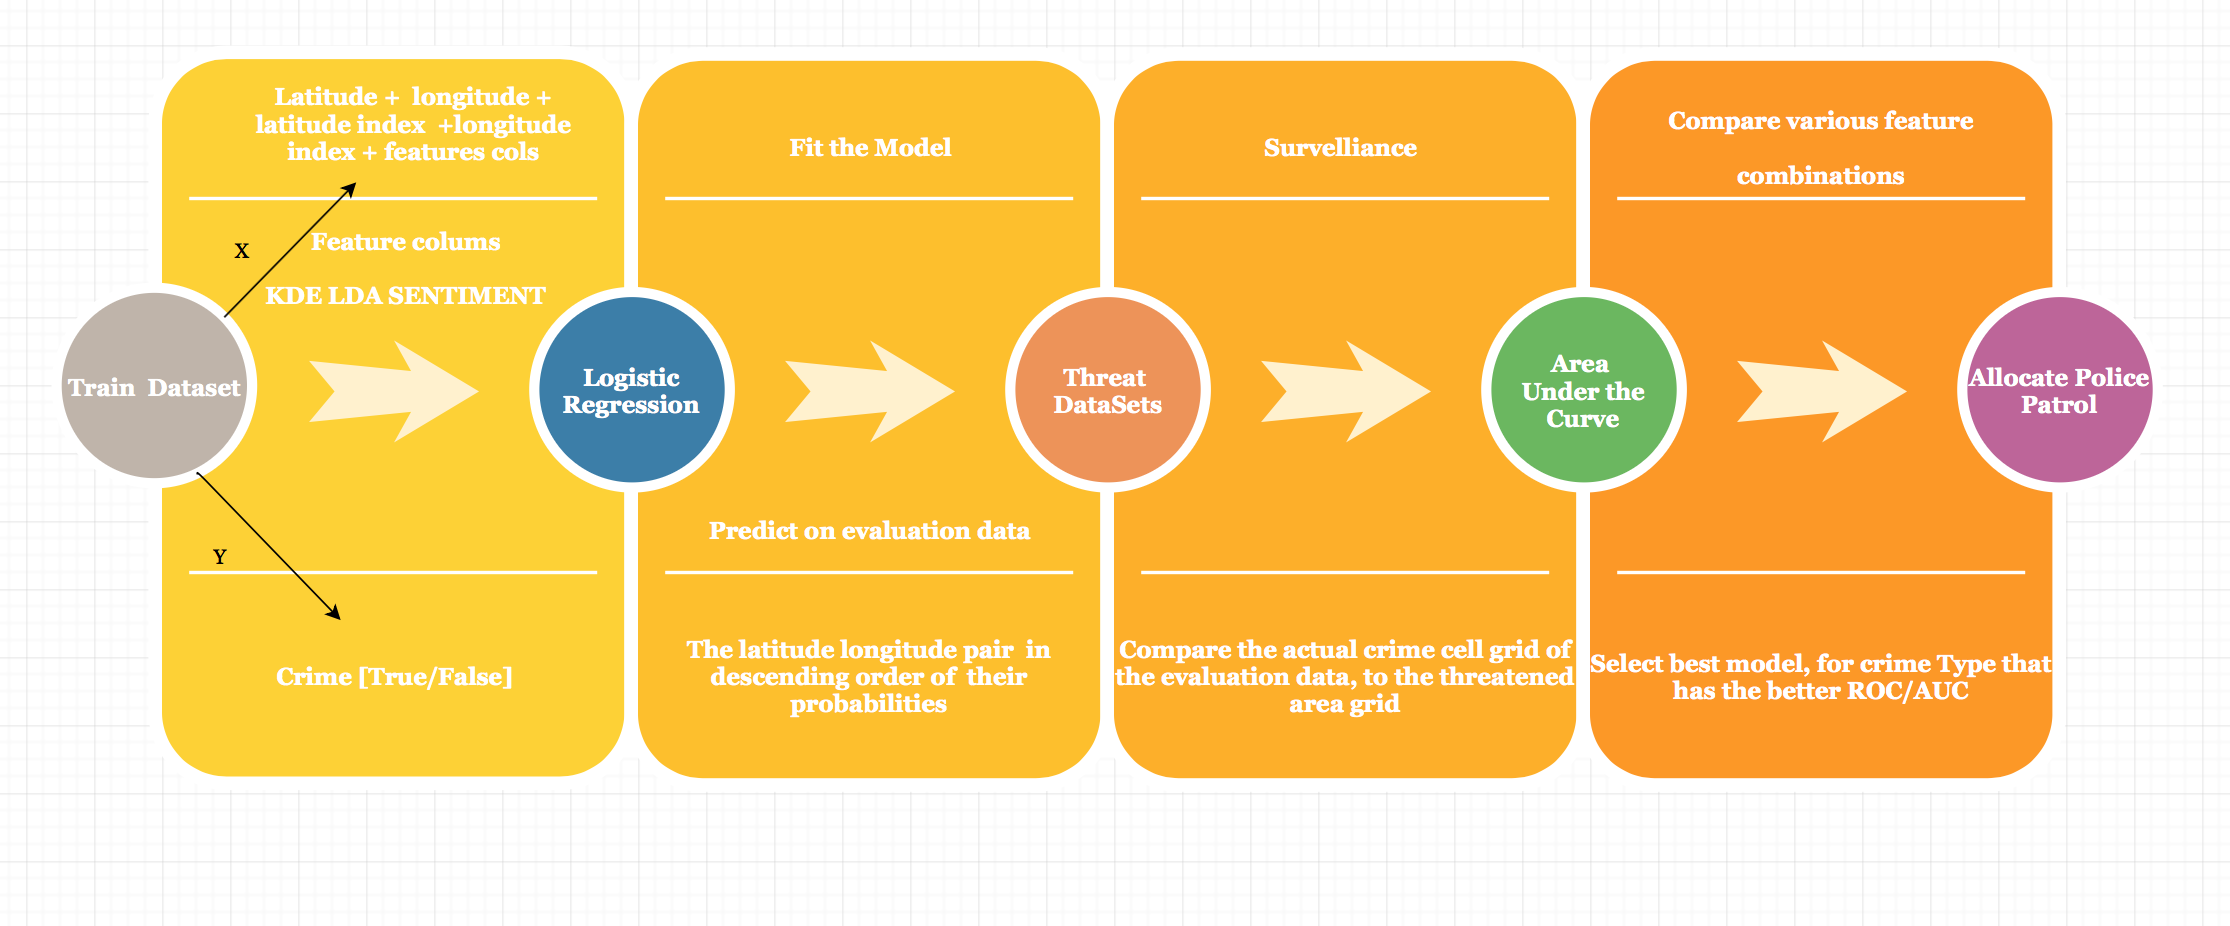

In [41]:
from IPython.display import Image
PATH = "/Users/varsha/Desktop/File/My code/"
Image(filename = PATH + "data2.png", width=1000, height=1000)



In [30]:
surveillance_data, threat_datasets = generate_surveillance_data(train_dataset,
                                                                evaluation_dataset)

### Logic Regression Coefficients
*Note: All features were standatarized, therefore there is a meaning for coefficeints comparing.*

#### SENTIMENT model

Most dominant coefs indices: [1 0]


1

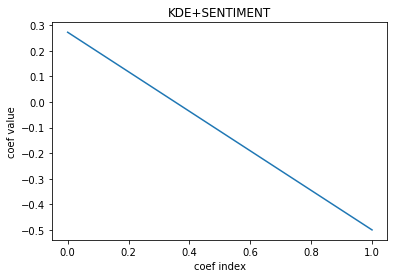

In [31]:
plot_log_reg_coef(threat_datasets, 'KDE+SENTIMENT')

#### KDE+LDA model

Most dominant coefs indices: [ 94 208  82 104 113]


94

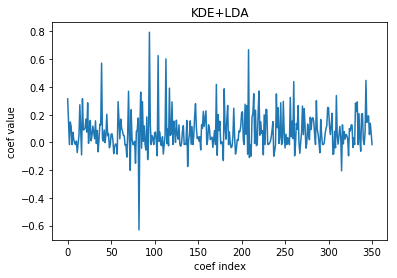

In [32]:
plot_log_reg_coef(threat_datasets, 'KDE+LDA')

In [33]:
train_dataset['Y'].value_counts()

True     5952
False    1470
Name: crime, dtype: int64

#### KDE+SENTIMENT+LDA model

Most dominant coefs indices: [ 95 209  83 114  40]


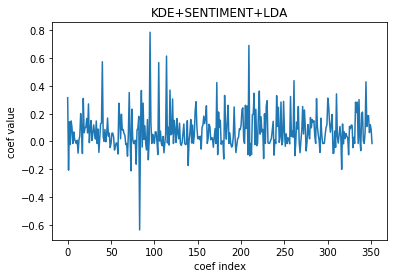

In [34]:
most_dominant_coefs_index = plot_log_reg_coef(threat_datasets, 'KDE+SENTIMENT+LDA') - 2

Examining the top words for the most dominant logistic regression coefficent topic:

In [35]:
get_topic_top_words_LDA(most_dominant_coefs_index,
                        train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 15)


['url',
 '.',
 'Retail',
 'Harbor',
 'Freight',
 'Tools',
 'Corner',
 ',',
 '…',
 'Facility',
 '..',
 'Crew',
 'Performance',
 'Inn',
 'Hideout']

### Surveillance Plot & AUC

In [37]:
normalized_surveillance_data = surveillance_data.cumsum(axis=1) / surveillance_data.sum(axis=1)[:, None]

### One day prediction

56.538961038961034 KDE
67.18831168831167 KDE+SENTIMENT
85.72077922077922 KDE+LDA
85.72077922077922 KDE+SENTIMENT+LDA
100.03246753246754 ACTUAL


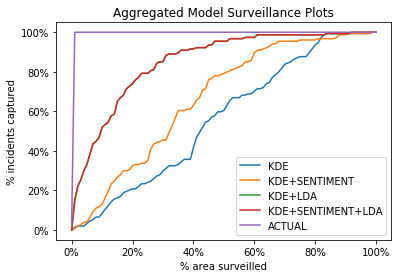

In [36]:
plot_surveillance_data(normalized_surveillance_data, threat_datasets.keys())


In [38]:
a= calc_AUCs(normalized_surveillance_data, threat_datasets)

In [39]:
a

,KDE,KDE+SENTIMENT,KDE+LDA,KDE+SENTIMENT+LDA
KDE+SENTIMENT,0.106518,,,
KDE+LDA,0.291626,0.185109,,
KDE+SENTIMENT+LDA,0.291602,0.185084,-0.000025,
ACTUAL,0.437536,0.331018,0.145910,0.145934


## Full Training & Evaluation over all the period (~60 steps of 31 days)


In [43]:
is_full_run = True

In [44]:
if is_full_run:
    agg_surveillance_data, all_threat_datasets = generate_all_data_surveillance_data(crimes_data, tweets_data, 31)   

100%|██████████| 42/42 [2:23:39<00:00, 159.63s/it]  


In [46]:
if is_full_run:
    print('AUC betwwen models')
    print(calc_AUCs(agg_surveillance_data, all_threat_datasets[0][1].keys()))

AUC betwwen models
                        KDE KDE+SENTIMENT    KDE+LDA KDE+SENTIMENT+LDA
KDE+SENTIMENT      0.101871                                           
KDE+LDA            0.273711      0.171840                             
KDE+SENTIMENT+LDA  0.273659      0.171788  -0.000052                  
ACTUAL             0.435156      0.333285   0.161445          0.161496


In [55]:
def calc_AUCs_new(agg_surveillance_data, model_names):
    """
    Calculate the Area Under the Curve (AUC) for all the pairs for models.
    """

    model_names_list = list(model_names)
    aucs = pd.DataFrame(columns=model_names_list[:-1], index=model_names_list[1:], dtype=float)

    step_for_precentage = int(len(agg_surveillance_data[0]) / 100)
    agg_surveillance_precentages = agg_surveillance_data[:,
                                                         ::step_for_precentage]

    for model_index, model_name in enumerate(model_names):
        plt.plot(agg_surveillance_precentages[model_index], label=model_name)
        print(agg_surveillance_precentages[model_index].sum(),model_name)
    precentage_ticks = ['{}%'.format(p) for p in range(0, 101, 20)]

    plt.xticks(range(0, 101, 20), precentage_ticks)
    plt.yticks(np.arange(0, 1.1, 0.2), precentage_ticks)
    plt.title('Aggregated Model Surveillance Plots')
    plt.xlabel('% area surveilled')
    plt.ylabel('% incidents captured')
    plt.legend(loc="lower right")
               
        

AUC betwwen models
56.725663716814154 KDE
66.92839903459374 KDE+SENTIMENT
84.13354786806114 KDE+LDA
84.12421560740144 KDE+SENTIMENT+LDA
100.02139983909896 ACTUAL
None


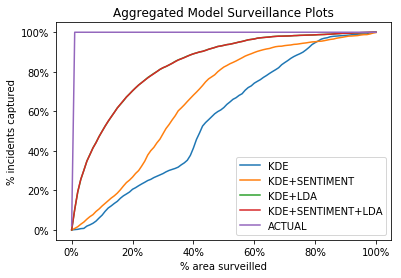

In [56]:
if is_full_run:
    print('AUC betwwen models')
    print(calc_AUCs_new(agg_surveillance_data, all_threat_datasets[0][1].keys()))